## Example 1: testing operators

In this example, we test some simple mathematical relationships for discrete numerical operators. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import geoana
import discretize
from discretize.Tests import checkDerivative as check_derivative
from pymatsolver import Pardiso

from SimPEG.EM.Static import DC as dc
from SimPEG import Maps as maps

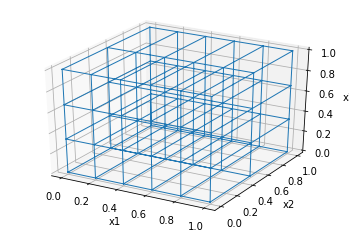

In [2]:
mesh = discretize.TensorMesh([5, 2, 3])
mesh.plotGrid();

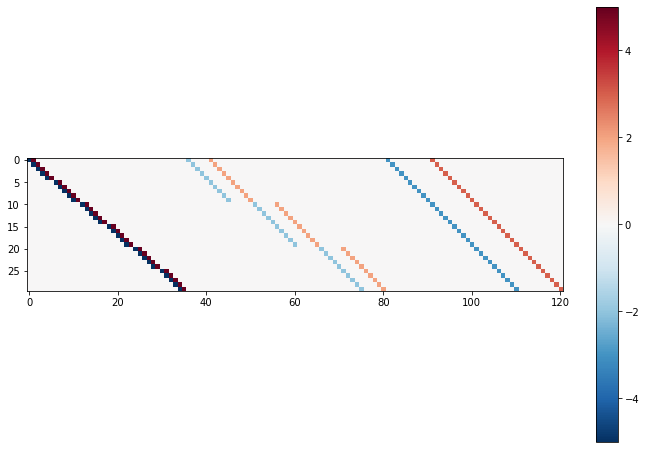

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
plt.colorbar(plt.imshow(mesh.faceDiv.todense(), cmap="RdBu_r"));

In [4]:
v = np.random.rand(mesh.nE)
print(np.allclose(mesh.faceDiv * mesh.edgeCurl * v, 0))

True


## Example 2: comparing with analytics or simplified models

- closed form expressions
- asymptotics
- ...

### part 1: Compute a numerical solution

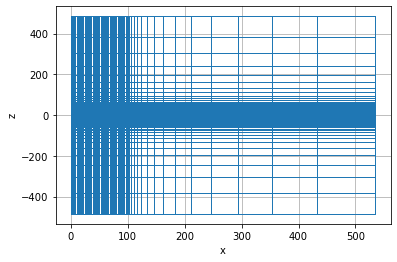

In [5]:
cs = 2
nc = 100/cs
npad = 15
mesh = discretize.CylMesh(
    [[(cs, nc), (cs, npad, 1.3)], [2*np.pi], [(cs, npad, -1.3), (cs, nc), (cs, npad, 1.3)]],
    x0="0CC"
)

fig, ax = plt.subplots(1, 1)
mesh.plotGrid(ax=ax)

In [6]:
src_a = np.r_[0., 0., 1]
src_b = np.r_[0., 0., -1]

source = dc.Src.Dipole([], src_a, src_b)

In [7]:
survey = dc.Survey([source])
simulation = dc.Problem3D_CC(mesh, sigmaMap=maps.IdentityMap(mesh), Solver=Pardiso, bc_type='Dirichlet')

simulation.pair(survey)

Homogeneous Dirichlet is the natural BC for this CC discretization.


In [8]:
sigma = 1
fields = simulation.fields(sigma * np.ones(mesh.nC))

### compute analytical solution 

In [9]:
edipole = geoana.em.fdem.ElectricDipoleWholeSpace(
    location=np.r_[0., 0., 0.], frequency=0., sigma=sigma, 
    current=1., length=np.abs(src_b[2] - src_a[2]), orientation='z'
)

In [10]:
jana_x = edipole.current_density(mesh.gridFx)[:, 0]
jana_z = edipole.current_density(mesh.gridFz)[:, 2]

jana = np.hstack([jana_x, jana_z])

In [11]:
def plot_current_density(j, ax, xlim=None, zlim=None, clim=None, title=None):
    out = mesh.plotImage(
        np.real(j), view="vec", vType="F", ax=ax, mirror=True, 
        pcolorOpts={"norm":LogNorm()}, range_x=xlim, range_y=zlim,
        clim=clim
    )
    plt.colorbar(out[0], ax=ax)
    
    if title is not None:
        ax.set_title(title)

In [12]:
fields[:, "j"].shape

(10465, 1)

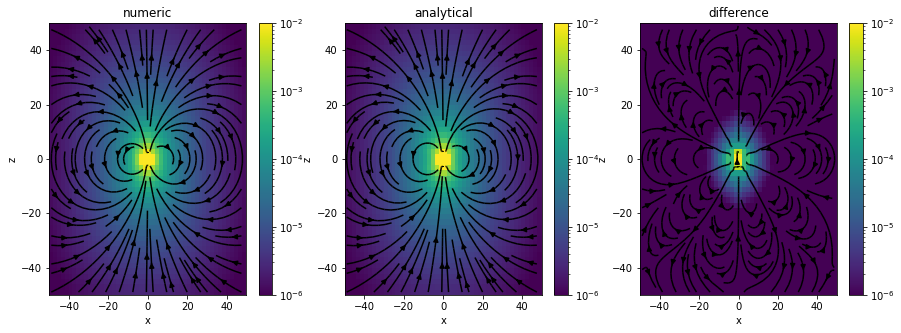

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

xlim = 50*np.r_[-1, 1]
zlim = 50*np.r_[-1, 1]
clim = np.r_[1e-6, 1e-2]

plot_current_density(fields[:, "j"], ax[0], xlim=xlim, zlim=zlim, clim=clim, title="numeric")
plot_current_density(jana, ax[1], xlim=xlim, zlim=zlim, clim=clim, title="analytical")
plot_current_density(discretize.utils.mkvc(fields[:, "j"])-jana, ax[2], xlim=xlim, zlim=zlim, clim=clim, title="difference")

## Example 3: testing gradients

Taylor series 

$$
f(x + \Delta x) \approx f(x) + J \Delta x + \mathcal{O}(h^2)
$$

Reference: 

https://doi.org/10.1137/1.9781611973808

In [32]:
def weighted_l2(m, W):
    return 0.5 * m.T * W.T * (W * m)

def weighted_l2_deriv(m, W, v):
    return m.T  * W.T * (W * v)


In [37]:
n = 10
W = np.random.rand(n, n)
m0 = np.random.rand(n)

def test_deriv(m):
    return weighted_l2(m, W), lambda v: weighted_l2_deriv(m0, W, v)

check_derivative(test_deriv, m0, num=3, plotIt=False)

==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    1.324e-01     1.454e-02      nan
 1   1.00e-02    1.314e-02     1.454e-04      2.000
 2   1.00e-03    1.314e-03     1.454e-06      2.000
========================= PASS! =========================
Testing is important.



True

## Example 4: testing adjoints

$$
w^\top J v = v^\top J^\top w
$$

## Some ideas for testing when you don't know the answer

### Check with other solutions
- comparing with established codes 
- comparing independently developed solutions

### Consistency over time
- save some result, check that you can still reproduce them if you make changes
- visual checks, save and re-create figures 

### Behaviour   
- convergence properties (mathematical or algorithmic) 
- scaling properties with number of parameters / problem size

### Realm of reasonable solutions
- strictly positive?
   - throw random numbers at it, are the results physical ([fuzzing](https://en.wikipedia.org/wiki/Fuzzing))
   - what should your code do with non-sense
- conserved quantities (conservation of energy)
   - if not, then how does it behave
  
### other ideas ...
- what do you **know** about your problem / code and how do you encode that so it can be automatically checked 
- ...? 

## Note: when you find a bug, write a test for it

# Testing isn't only about verifying correctness - it is about building layers of evidence